### Final (?) checks on the anlytical implementation

In [1]:
import oLIMpus
import zeus21
from matplotlib import pyplot as plt
import numpy as np
from zeus21 import LIM
import matplotlib as mpl
from tqdm import tqdm
from scipy.interpolate import interp1d

import scipy.fftpack as fft
from scipy import ndimage

from matplotlib.cm import get_cmap
import numexpr as ne
#set up the CLASS cosmology

from classy import Class
ClassCosmo = Class()
ClassCosmo.compute()

plt.rcParams.update({"text.usetex": True, "font.family": "Times new roman"}) # Use latex fonts
plt.rcParams['lines.linewidth'] = 2
colors = ['#001219', '#005f73', '#0a9396', '#94d2bd', '#e9d8a6', '#ee9b00', '#ca6702', '#bb3e03', '#ae2012', '#9b2226']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors) # Set the color palette as default

In [2]:
# define all the input params
CosmoParams_input = zeus21.Cosmo_Parameters_Input(HMF_CHOICE='ST')
CosmoParams_use,ClassyCosmo_use, CorrFclass_21_use ,HMFintclass_use =  zeus21.cosmo_wrapper(CosmoParams_input)

AstroParams_use = zeus21.Astro_Parameters(CosmoParams_use,STOCHASTICITY = False,)

AstroParams_second = zeus21.Astro_Parameters(CosmoParams_use,STOCHASTICITY = False,second_order_SFRD=True)


AstroParams_stoch = zeus21.Astro_Parameters(CosmoParams_use,STOCHASTICITY = True,second_order_SFRD=False)

ZMIN = 5.0 #down to which z we compute the evolution
RSDMODE = 0 #which RSD mode you want, 0 is no RSDs (real space), 1 is spherical (as simulations usually take), 2 is mu~1 (outside the wedge, most relevant for observations)

In [3]:
CoeffStructure_21_use = zeus21.get_T21_coefficients(CosmoParams_use, ClassyCosmo_use, AstroParams_use, HMFintclass_use, zmin=ZMIN)

PS21_use = zeus21.Power_Spectra(CosmoParams_use, AstroParams_use, ClassyCosmo_use, CorrFclass_21_use, CoeffStructure_21_use, RSD_MODE = RSDMODE)

In [4]:
CoeffStructure_21_second = zeus21.get_T21_coefficients(CosmoParams_use, ClassyCosmo_use, AstroParams_second, HMFintclass_use, zmin=ZMIN)

PS21_second = zeus21.Power_Spectra(CosmoParams_use, AstroParams_second, ClassyCosmo_use, CorrFclass_21_use, CoeffStructure_21_second, RSD_MODE = RSDMODE)

In [5]:
# CoeffStructure_21_stoch = zeus21.get_T21_coefficients(CosmoParams_use, ClassyCosmo_use, AstroParams_stoch, HMFintclass_use, zmin=ZMIN)

# PS21_stoch = zeus21.Power_Spectra(CosmoParams_use, AstroParams_stoch, ClassyCosmo_use, CorrFclass_21_use, CoeffStructure_21_stoch, RSD_MODE = RSDMODE)


In [6]:
OIII_Yang_input = oLIMpus.LineParams_Input(\
                 LINE = 'OIII',
                 nu_rest = 6.042e14, 
                 OBSERVABLE_LIM = 'Inu',
                 _R = 4,
                 LINE_MODEL = 'Yang24',
                 sigma_LSFR = 0.)
OIII_Yang = oLIMpus.Line_Parameters(OIII_Yang_input) 
OIII_Yang_corr = oLIMpus.Correlations_LIM(OIII_Yang, CosmoParams_use, ClassyCosmo_use)


In [7]:
OIII_Yang_lin_coeff = oLIMpus.get_LIM_coefficients(CosmoParams_use,  AstroParams_use, HMFintclass_use, OIII_Yang, zmin=ZMIN)

OIII_Yang_lin_PSLIM = oLIMpus.Power_Spectra_LIM(CosmoParams_use, AstroParams_use, OIII_Yang, OIII_Yang_corr, OIII_Yang_lin_coeff, RSD_MODE = RSDMODE)


In [8]:
OIII_Yang_quad_coeff = oLIMpus.get_LIM_coefficients(CosmoParams_use,  AstroParams_second, HMFintclass_use, OIII_Yang, zmin=ZMIN)

OIII_Yang_quad_PSLIM = oLIMpus.Power_Spectra_LIM(CosmoParams_use, AstroParams_second, OIII_Yang, OIII_Yang_corr, OIII_Yang_quad_coeff, RSD_MODE = RSDMODE)


In [9]:
# OIII_Yang_stoch_coeff = oLIMpus.get_LIM_coefficients(CosmoParams_use,  AstroParams_stoch, HMFintclass_use, OIII_Yang, zmin=ZMIN)

# OIII_Yang_stoch_PSLIM = oLIMpus.Power_Spectra_LIM(CosmoParams_use, AstroParams_use, OIII_Yang, OIII_Yang_corr, OIII_Yang_stoch_coeff, RSD_MODE = RSDMODE)


## 1) Lognormal approximation

In [10]:
Nsigmad = 4 #how many sigmas we explore
Nds =11 #how many deltas
deltatab_norm = np.linspace(-Nsigmad,Nsigmad,Nds)[np.newaxis,np.newaxis,:]

In [11]:
zArray, rArray, mArray, deltaNormArray = np.meshgrid(CoeffStructure_21_use.zintegral, CoeffStructure_21_use.Rtabsmoo, HMFintclass_use.Mhtab, deltatab_norm, indexing = 'ij', sparse = True)

zArray_LIM, rArray_LIM, mArray_LIM, deltaNormArray_LIM = np.meshgrid(OIII_Yang_lin_coeff.zintegral, OIII_Yang_lin_coeff.Rtabsmoo_LIM, HMFintclass_use.Mhtab, deltatab_norm, indexing = 'ij', sparse = True)

rGreaterArray = np.zeros_like(zArray) + rArray
rGreaterArray[CosmoParams_use.chiofzint(zArray) + rArray >= CosmoParams_use.chiofzint(50)] = np.nan
zGreaterArray = CosmoParams_use.zfofRint(CosmoParams_use.chiofzint(zArray) + rGreaterArray)
whereNotNans = np.invert(np.isnan(rGreaterArray))


rGreaterArray_LIM = np.zeros_like(zArray_LIM) + rArray_LIM
rGreaterArray_LIM[CosmoParams_use.chiofzint(zArray_LIM) + rArray_LIM >= CosmoParams_use.chiofzint(50)] = np.nan
zGreaterArray_LIM = CosmoParams_use.zfofRint(CosmoParams_use.chiofzint(zArray_LIM) )#+ rGreaterArray)  !!! because it's local !!!
whereNotNans_LIM = np.invert(np.isnan(rGreaterArray_LIM))


In [12]:
sigmaR = np.zeros((len(CoeffStructure_21_use.zintegral), len(CoeffStructure_21_use.Rtabsmoo), 1, 1))
sigmaR[whereNotNans] = HMFintclass_use.sigmaRintlog((np.log(rGreaterArray)[whereNotNans], zGreaterArray[whereNotNans]))

sigmaM = np.zeros((len(CoeffStructure_21_use.zintegral), len(CoeffStructure_21_use.Rtabsmoo), len(HMFintclass_use.Mhtab), 1))
sigmaM = HMFintclass_use.sigmaintlog((np.log(mArray), zGreaterArray))

modSigmaSq = sigmaM**2 - sigmaR**2
indexTooBig = (modSigmaSq <= 0.0)
modSigmaSq[indexTooBig] = np.inf #if sigmaR > sigmaM the halo does not fit in the radius R. Cut the sum
modSigma = np.sqrt(modSigmaSq)

nu0 = CosmoParams_use.delta_crit_ST / sigmaM
nu0[indexTooBig] = 1.0

deltaArray = deltaNormArray * sigmaR

modd = CosmoParams_use.delta_crit_ST - deltaArray
nu = modd / modSigma

EPS_HMF_corr = (nu/nu0) * (sigmaM/modSigma)**2.0 * np.exp(-CosmoParams_use.a_corr_EPS * (nu**2-nu0**2)/2.0 ) * (1.0 + deltaArray)


In [13]:
sigmaR_LIM = np.zeros((len(OIII_Yang_lin_coeff.zintegral), 1, 1, 1))
sigmaR_LIM[whereNotNans_LIM] = HMFintclass_use.sigmaRintlog((np.log(rGreaterArray_LIM)[whereNotNans_LIM], zGreaterArray_LIM[whereNotNans_LIM]))

sigmaM_LIM = np.zeros((len(OIII_Yang_lin_coeff.zintegral),1, len(HMFintclass_use.Mhtab), 1)) 
sigmaM_LIM = HMFintclass_use.sigmaintlog((np.log(mArray_LIM), zGreaterArray_LIM))

modSigmaSq_LIM = sigmaM_LIM**2 - sigmaR_LIM**2
indexTooBig_LIM = (modSigmaSq_LIM <= 0.0)
modSigmaSq_LIM[indexTooBig_LIM] = np.inf #if sigmaR > sigmaM the halo does not fit in the radius R. Cut the sum
modSigma_LIM = np.sqrt(modSigmaSq_LIM)

nu0_LIM = CosmoParams_use.delta_crit_ST / sigmaM_LIM
nu0_LIM[indexTooBig_LIM] = 1.0

deltaArray_LIM = deltaNormArray_LIM * sigmaR_LIM

modd_LIM = CosmoParams_use.delta_crit_ST - deltaArray_LIM
nu_LIM = modd_LIM / modSigma_LIM

EPS_HMF_corr_LIM = (nu_LIM/nu0_LIM) * (sigmaM_LIM/modSigma_LIM)**2.0 * np.exp(-CosmoParams_use.a_corr_EPS * (nu_LIM**2-nu0_LIM**2)/2.0 ) * (1.0 + deltaArray_LIM)


${\rm SFRD}(\delta_R) = (1+\delta_R)\int dM \dfrac{dn}{dM}(\delta_R)\mathcal{E}\,{\rm SFR}(M_h)$

$\to {\rm SFRD}(\delta_R) = \overline{\rm SFRD}\exp\left[\gamma_R\delta_R - \gamma_R\sigma^2/2\right]=\overline{\rm SFRD}\exp\left[\gamma_R\tilde{\delta}_R\right]$

$\to {\rm SFRD}(\delta_R) = \overline{\rm SFRD}\,{\exp\left[\gamma_R\delta_R+\gamma_R^{\rm NL}\delta_R^2\right]}\left(\dfrac{\exp\left[\gamma_R^2\sigma^2/(2-4\gamma_R^{\rm NL}\sigma^2)\right]}{\sqrt{1-2\gamma_R^{\rm NL}\sigma^2}}\right)^{-1}$

In [14]:
_iRnonlinear = np.arange(CosmoParams_use.indexmaxNL)

sigmaR_lin = CoeffStructure_21_use.sigmaofRtab[:, _iRnonlinear,np.newaxis] 
sigmaR_quad = CoeffStructure_21_second.sigmaofRtab[:, _iRnonlinear,np.newaxis] 
sigmaR_LIMlin = OIII_Yang_lin_coeff.sigmaofRtab_LIM[:, :,np.newaxis] 
sigmaR_LIMquad = OIII_Yang_quad_coeff.sigmaofRtab_LIM[:, :,np.newaxis] 

# different size between LIM and 21cm case
# same between lin and quad for each case
deltaArray_21 = deltatab_norm * sigmaR_lin

SFRD_lin = np.exp(CoeffStructure_21_use.gamma_II_index2D[:, _iRnonlinear,np.newaxis] *deltaArray_21 )
SFRD_quad = np.exp(CoeffStructure_21_second.gamma_II_index2D[:, _iRnonlinear,np.newaxis] *deltaArray_21 + CoeffStructure_21_second.gamma2_II_index2D[:, _iRnonlinear,np.newaxis] *deltaArray_21**2)

integrand_II = EPS_HMF_corr * oLIMpus.sfrd.SFRD_II_integrand(AstroParams_second, CosmoParams_use, HMFintclass_use, mArray, zGreaterArray, zGreaterArray)
SFRD_full = np.trapz(integrand_II, HMFintclass_use.logtabMh, axis = 2)

${\rho}_L(\delta_R) = (1+\delta_R)\int dM \dfrac{dn}{dM}(\delta_R)\mathcal{E}\,L({\rm SFR}(M_h))$

$\to {\rho_L}(\delta_R) = \overline{\rho}_L\exp\left[\gamma_R^{\rm LIM}\delta_R - \gamma_R^{\rm LIM}\sigma^2/2\right]=\overline{\rm SFRD}\exp\left[\gamma_R^{\rm LIM}\tilde{\delta}_R\right]$

$\to {\rho_L}(\delta_R) = \overline{\rho_L}\,{\exp\left[\gamma_R^{\rm LIM}\delta_R+\gamma_R^{\rm LIM,NL}\delta_R^2\right]}\left(\dfrac{\exp\left[(\gamma_R^{\rm LIM})^2\sigma^2/(2-4\gamma_R^{\rm LIM,NL}\sigma^2)\right]}{\sqrt{1-2\gamma_R^{\rm LIM,NL}\sigma^2}}\right)^{-1}$

In [15]:
sigmaR_LIMlin = OIII_Yang_lin_coeff.sigmaofRtab_LIM[:, :,np.newaxis] 
sigmaR_LIMquad = OIII_Yang_quad_coeff.sigmaofRtab_LIM[:, :,np.newaxis] 

# different size between LIM and 21cm case
# same between lin and quad for each case
deltaArray_LIM1 = deltatab_norm * sigmaR_LIMlin

rhoL_lin = np.exp(OIII_Yang_lin_coeff.gammaLIM_index[:, :,np.newaxis] *deltaArray_LIM1 ) 

norm = ((np.exp(OIII_Yang_quad_coeff.gammaLIM_index[:, :,np.newaxis]**2*sigmaR_LIMquad**2/(2-4*OIII_Yang_quad_coeff.gamma2_LIM_index[:, :,np.newaxis]*sigmaR_LIMquad**2)))/np.sqrt(1-2*OIII_Yang_quad_coeff.gamma2_LIM_index[:, :,np.newaxis]*sigmaR_LIMquad**2))

rhoL_quad = np.exp(OIII_Yang_quad_coeff.gammaLIM_index[:, :,np.newaxis] *deltaArray_LIM1 + OIII_Yang_quad_coeff.gamma2_LIM_index[:, :,np.newaxis] *deltaArray_LIM1**2) #/ norm

integrand_II_LIM = EPS_HMF_corr_LIM * oLIMpus.LIM.rhoL_integrand(False,OIII_Yang, AstroParams_use, CosmoParams_use, HMFintclass_use, mArray_LIM,zGreaterArray_LIM)
rhoL_full = np.trapz(integrand_II_LIM, HMFintclass_use.logtabMh, axis = 2)


In [16]:
z_id = 30
R_id = 11
delta0_id = 5

Lbox = 400
Lbox1 = 50
Nbox = 100
Nbox1 = 50

In [17]:
boxes_oLIMpus = oLIMpus.maps_LIM.CoevalBoxes_percell('full',OIII_Yang_lin_coeff,OIII_Yang_corr,OIII_Yang_lin_PSLIM,CoeffStructure_21_use,OIII_Yang_quad_coeff.zintegral[z_id],OIII_Yang,AstroParams_use,HMFintclass_use,CosmoParams_use,Lbox,Nbox,1065)

delta_box = boxes_oLIMpus.delta_box
SFRD_box = boxes_oLIMpus.SFRD_box/np.mean(boxes_oLIMpus.SFRD_box)
full_LIM_box = boxes_oLIMpus.Inu_box
LIM_box = full_LIM_box/np.mean(boxes_oLIMpus.Inu_box)


done analytical in 0.15568804740905762
Done EPS corr in 0.5834007263183594
SFR ok in 0.5837397575378418
Integrand ok in 1.1254310607910156
SFRD ok in 1.407905101776123
rho box ok in 1.6881036758422852


In [18]:
boxes_oLIMpus = oLIMpus.maps_LIM.CoevalBoxes_percell('full',OIII_Yang_lin_coeff,OIII_Yang_corr,OIII_Yang_lin_PSLIM,CoeffStructure_21_use,OIII_Yang_quad_coeff.zintegral[z_id],OIII_Yang,AstroParams_use,HMFintclass_use,CosmoParams_use,Lbox,Nbox1,1065)

delta_box1 = boxes_oLIMpus.delta_box
SFRD_box1 = boxes_oLIMpus.SFRD_box/np.mean(boxes_oLIMpus.SFRD_box)
full_LIM_box1 = boxes_oLIMpus.Inu_box
LIM_box1 = full_LIM_box1/np.mean(boxes_oLIMpus.Inu_box)

done analytical in 0.018639087677001953
Done EPS corr in 0.07846403121948242
SFR ok in 0.07882523536682129
Integrand ok in 0.15014076232910156
SFRD ok in 0.18338942527770996
rho box ok in 0.21723699569702148


In [19]:
boxes_oLIMpus = oLIMpus.maps_LIM.CoevalBoxes_percell('full',OIII_Yang_lin_coeff,OIII_Yang_corr,OIII_Yang_lin_PSLIM,CoeffStructure_21_use,OIII_Yang_quad_coeff.zintegral[z_id],OIII_Yang,AstroParams_use,HMFintclass_use,CosmoParams_use,Lbox1,Nbox1,1065)

delta_box2 = boxes_oLIMpus.delta_box
SFRD_box2 = boxes_oLIMpus.SFRD_box/np.mean(boxes_oLIMpus.SFRD_box)
full_LIM_box2 = boxes_oLIMpus.Inu_box
LIM_box2 = full_LIM_box2/np.mean(boxes_oLIMpus.Inu_box)


done analytical in 0.023110389709472656
Done EPS corr in 0.08014512062072754
SFR ok in 0.0811302661895752
Integrand ok in 0.15530800819396973
SFRD ok in 0.18955278396606445
rho box ok in 0.2235701084136963


In [20]:
bins_21 = deltaArray_21[z_id,R_id]
use_bins = bins_21 

bin_edges = np.zeros(len(use_bins) + 1)
bin_edges[1:-1] = (use_bins[:-1] + use_bins[1:]) / 2
bin_edges[0] = use_bins[0] - (bin_edges[1] - use_bins[0])
bin_edges[-1] = use_bins[-1] + (use_bins[-1] - bin_edges[-2])

bin_indices = np.digitize(delta_box*np.std(delta_box), bin_edges)
SFRD_binned =([SFRD_box[bin_indices == i] for i in range(1, len(bin_edges))])

bin_indices1 = np.digitize(delta_box1*np.std(delta_box1), bin_edges)
SFRD_binned1 =([SFRD_box1[bin_indices1 == i] for i in range(1, len(bin_edges))])

bin_indices2 = np.digitize(delta_box2*np.std(delta_box2), bin_edges)
SFRD_binned2 =([SFRD_box2[bin_indices2 == i] for i in range(1, len(bin_edges))])

bins_LIM = deltaArray_LIM[z_id,0,0]
use_bins = bins_LIM#sigmaR_lin[z_id,R_id,0]
bin_edges = np.zeros(len(use_bins) + 1)
bin_edges[1:-1] = (use_bins[:-1] + use_bins[1:]) / 2
bin_edges[0] = use_bins[0] - (bin_edges[1] - use_bins[0])
bin_edges[-1] = use_bins[-1] + (use_bins[-1] - bin_edges[-2])

LIM_binned = ([LIM_box[bin_indices == i] for i in range(1, len(bin_edges))])
LIM1_binned = ([LIM_box1[bin_indices1 == i] for i in range(1, len(bin_edges))])
LIM2_binned = ([LIM_box2[bin_indices2 == i] for i in range(1, len(bin_edges))])

In [21]:
SFRD_plot = np.zeros(len(bins_21))
SFRD_plot1 = np.zeros(len(bins_21))
SFRD_plot2 = np.zeros(len(bins_21))
for i in range(len(bins_21)):
    SFRD_plot[i] = np.mean(SFRD_binned[i])
    SFRD_plot1[i] = np.mean(SFRD_binned1[i])
    SFRD_plot2[i] = np.mean(SFRD_binned2[i])

LIM_plot = np.zeros(len(bins_LIM))
LIM_plot1 = np.zeros(len(bins_LIM))
LIM_plot2 = np.zeros(len(bins_LIM))
for i in range(len(bins_LIM)):
    LIM_plot[i] = np.mean(LIM_binned[i])
    LIM_plot1[i] = np.mean(LIM1_binned[i])
    LIM_plot2[i] = np.mean(LIM2_binned[i])

Text(0, 0.5, '$\\rho_{L}(\\delta_{R}|z )/\\bar{\\rho}_L$')

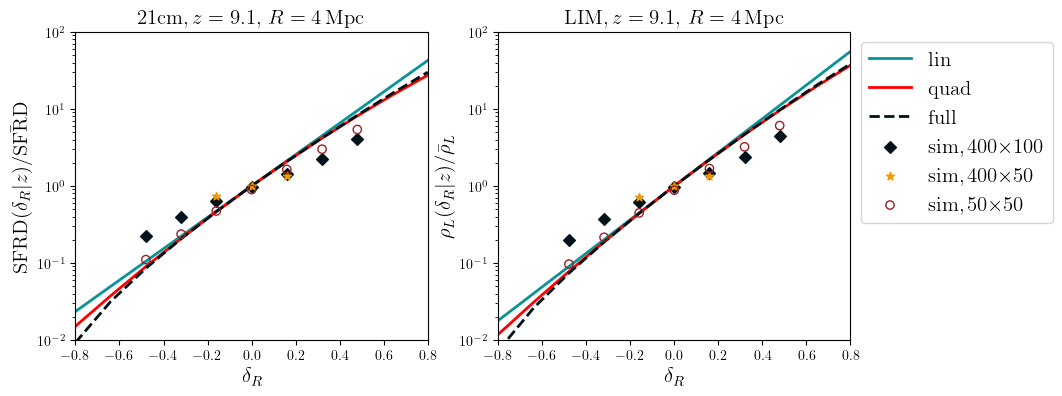

In [22]:
plt.figure(figsize=(10,4))


plt.subplot(121)
plt.semilogy(bins_21,SFRD_lin[z_id,R_id],label=r'$\rm lin$',color=colors[2],zorder=1)
plt.semilogy(bins_21,SFRD_quad[z_id,R_id],label=r'$\rm quad$',color='r',zorder=1)
plt.semilogy(bins_21, SFRD_full[z_id,R_id]/SFRD_full[z_id,R_id,delta0_id], label=r'$\rm full$',ls='--',color=colors[0],zorder=1)

plt.scatter(bins_21,SFRD_plot,label=r'$\rm sim,%g$'%Lbox+r'$\times%g$'%Nbox,color=colors[0],marker='D',zorder=8)
plt.scatter(bins_21,SFRD_plot1,label=r'$\rm sim,%g$'%Lbox+r'$\times%g$'%Nbox1,color=colors[5],marker='*',zorder=9)
plt.scatter(bins_21,SFRD_plot2,label=r'$\rm sim,%g$'%Lbox1+r'$\times%g$'%Nbox1,color=colors[-1],marker='o',facecolor='none',zorder=10)


#plt.legend(loc=4,fontsize=15)
plt.xlim(-0.8,0.8)
plt.ylim(1e-2,1e2)
plt.title(r'${\rm 21cm,\,}z=%g$'%round(CoeffStructure_21_second.zintegral[z_id],1)+r'$,\,R=%g\,{\rm Mpc}$'%round(CoeffStructure_21_second.Rtabsmoo[R_id],1),fontsize=15)
plt.xlabel(r'$\delta_R$',fontsize=15)
plt.ylabel(r'${\rm SFRD}(\delta_{R}|z)/\bar{\rm SFRD}$',fontsize=15)

plt.subplot(122)
plt.semilogy(bins_LIM,rhoL_lin[z_id,0],label=r'$\rm lin$',color=colors[2],zorder=1)
plt.semilogy(bins_LIM,rhoL_quad[z_id,0],label=r'$\rm quad$',ls='-',color='r',zorder=1)
plt.semilogy(bins_LIM, rhoL_full[z_id,0]/rhoL_full[z_id,0,delta0_id], label=r'$\rm full$',ls='--',color=colors[0],zorder=1)

plt.scatter(bins_LIM,LIM_plot,label=r'$\rm sim,%g$'%Lbox+r'$\times%g$'%Nbox,color=colors[0],marker='D',zorder=8)
plt.scatter(bins_LIM,LIM_plot1,label=r'$\rm sim,%g$'%Lbox+r'$\times%g$'%Nbox1,color=colors[5],marker='*',zorder=9)
plt.scatter(bins_LIM,LIM_plot2,label=r'$\rm sim,%g$'%Lbox1+r'$\times%g$'%Nbox1,color=colors[-1],marker='o',facecolor='none',zorder=10)

plt.legend(bbox_to_anchor=(1,1),fontsize=15)
plt.xlim(-0.8,0.8)
plt.ylim(1e-2,1e2)
plt.title(r'${\rm LIM,\,}z=%g$'%round(OIII_Yang_quad_coeff.zintegral[z_id],1)+r'$,\,R=%g\,{\rm Mpc}$'%round(OIII_Yang._R,1),fontsize=15)
plt.xlabel(r'$\delta_R$',fontsize=15)
plt.ylabel(r'$\rho_{L}(\delta_{R}|z )/\bar{\rho}_L$',fontsize=15)

## 2) Cross correlation

In [23]:
def exponentialcorrelation(gamma1, gamma2, sigmaR1, sigmaR2, xi12):

    #note that it's in units of sigmaR (gamma 1 and 2 are for deltaR1 and deltaR2, gammaNL is the second-order correction)

    g1, g2 = gamma1*sigmaR1, gamma2*sigmaR2

    xi = xi12/(sigmaR1 * sigmaR2)# dimless, -1 to 1. 

    numerator = g1*g2 * xi 

    return np.exp(numerator)-1.0

### 21cm (Lyman$\alpha$ COMPONENT)

#### LINEAR CASE 

$\langle e^{\gamma_1\tilde{\delta}_1}e^{\gamma_2\tilde{\delta}_2}\rangle=\gamma_1\gamma_2\xi_{12} + \left[\exp[\gamma_1\gamma_2\xi_{12}]-1-\gamma_1\gamma_2\xi_{12}\right]$

#### QUADRATIC CASE 

$\langle e^{\gamma_1\tilde{\delta}_1+\gamma_1^{\rm NL}\tilde{\delta}_1^2}e^{\gamma_2\tilde{\delta}_2+\gamma_2^{\rm NL}\tilde{\delta}_2}\rangle=\gamma_1\gamma_2\xi_{12} + \left[\exp\left(\dfrac{N}{D}-\log\left(\sqrt{D}\mathcal{N}_1\mathcal{N}_2\right)\right)-1-\gamma_1\gamma_2\xi_{12}\right]$

$N = \gamma_1\gamma_2\xi_{12} + 2\gamma_1^2\sigma_1^2\left[\dfrac{1}{2}-\gamma_2^{\rm NL}\sigma_2^2\left(1-\dfrac{\xi_{12}}{\sigma_1^2\sigma_2^2}\right)\right] + 2\gamma_2^2\sigma_2^2\left[\frac{1}{2}-\gamma_1^{\rm NL}\sigma_1^2\left(1-\dfrac{\xi_{12}}{\sigma_1^2\sigma_2^2}\right)\right]$

$D = 1-2\gamma_1^{\rm NL}\sigma_1^2-2\gamma_2^{\rm NL}\sigma_2^2+4\gamma_1^{\rm NL}\sigma_1^2\gamma_2^{\rm NL}\sigma_2^2\left(1-\dfrac{\xi_{12}}{\sigma_1^2\sigma_2^2}\right)$

$\mathcal{N}_{1,2} = \dfrac{\exp\left[\gamma_{1,2}^2\sigma^2/(2-4\gamma_{1,2}^{\rm NL}\sigma^2)\right]}{\sqrt{1-2\gamma_{1,2}^{\rm NL}\sigma^2}}$


THESE QUANTITY ARE THEN MULTIPLIED BY $c_1,c_s$ AND SUMMED OVER $R$. 

SIMILAR COMPUTATION FOR $T_k$, THEN EVERYTHING GOES TO $T_{21}$. 

In [24]:
zGreaterMatrix100 = np.copy(CoeffStructure_21_use.zGreaterMatrix)
zGreaterMatrix100[np.isnan(zGreaterMatrix100)] = 100

_iRnonlinear = np.arange(CosmoParams_use.indexmaxNL)
corrdNL = CorrFclass_21_use.xi_RR_CF[np.ix_(_iRnonlinear,_iRnonlinear)]
#for R<RNL fix at RNL, avoids corelations blowing up at low R
corrdNL[0:CosmoParams_use.indexminNL,0:CosmoParams_use.indexminNL] = corrdNL[CosmoParams_use.indexminNL,CosmoParams_use.indexminNL]
corrdNL = corrdNL.reshape((1, *corrdNL.shape))

_coeffTx_units = CoeffStructure_21_use.coeff_Gammah_Tx_II #includes -10^40 erg/s/SFR normalizaiton and erg/K conversion factor

growthRmatrix = oLIMpus.cosmology.growth(CosmoParams_use,zGreaterMatrix100[:, _iRnonlinear])

coeffzp1xa = CoeffStructure_21_use.coeff1LyAzp * CoeffStructure_21_use.coeff_Ja_xa
coeffzp1Tx = CoeffStructure_21_use.coeff1Xzp

coeffR1xa = CoeffStructure_21_use.coeff2LyAzpRR_II[:,_iRnonlinear]
coeffR1Tx = CoeffStructure_21_use.coeff2XzpRR_II[:,_iRnonlinear]

coeffmatrixxa = coeffR1xa.reshape(len(CoeffStructure_21_use.zintegral), 1, len(_iRnonlinear),1) * coeffR1xa.reshape(len(CoeffStructure_21_use.zintegral), len(_iRnonlinear), 1,1)

# SarahLibanore : change to introduce quantities required in the second order correction
# --- #
growthRmatrix1 = growthRmatrix.reshape(len(CoeffStructure_21_use.zintegral), 1, len(_iRnonlinear),1)
growthRmatrix2 = growthRmatrix.reshape(len(CoeffStructure_21_use.zintegral), len(_iRnonlinear), 1,1)
growth_corr = growthRmatrix1 * growthRmatrix2

gammaR1 = CoeffStructure_21_use.gamma_II_index2D[:, _iRnonlinear] 
sigmaR1 = CoeffStructure_21_use.sigmaofRtab[:, _iRnonlinear] 
sR1 = (sigmaR1).reshape(len(CoeffStructure_21_use.zintegral), 1, len(_iRnonlinear),1)
sR2 = (sigmaR1).reshape(len(CoeffStructure_21_use.zintegral), len(_iRnonlinear), 1,1)

g1 = (gammaR1 * sigmaR1).reshape(len(CoeffStructure_21_use.zintegral), 1, len(_iRnonlinear),1)
g2 = (gammaR1 * sigmaR1).reshape(len(CoeffStructure_21_use.zintegral), len(_iRnonlinear), 1,1)
gammamatrixR1R1 = g1 * g2

corrdNL_gs = ne.evaluate('corrdNL * growth_corr/ (sR1 * sR2)')
gammaTimesCorrdNL = ne.evaluate('gammamatrixR1R1 * corrdNL_gs')

gammaR1NL = CoeffStructure_21_use.gamma2_II_index2D[:, _iRnonlinear] 
g1NL = (gammaR1NL * sigmaR1**2).reshape(len(CoeffStructure_21_use.zintegral), 1, len(_iRnonlinear),1)
g2NL = (gammaR1NL * sigmaR1**2).reshape(len(CoeffStructure_21_use.zintegral), len(_iRnonlinear), 1,1)

numerator_NL = ne.evaluate('gammaTimesCorrdNL+ g1 * g1 * (0.5 - g2NL * (1 - corrdNL_gs * corrdNL_gs)) + g2 * g2 * (0.5 - g1NL * (1 - corrdNL_gs * corrdNL_gs))')

denominator_NL = ne.evaluate('1. - 2 * g1NL - 2 * g2NL + 4 * g1NL * g2NL * (1 - corrdNL_gs * corrdNL_gs)')

norm1 = ne.evaluate('exp(g1 * g1 / (2 - 4 * g1NL)) / sqrt(1 - 2 * g1NL)') 
norm2 = ne.evaluate('exp(g2 * g2 / (2 - 4 * g2NL)) / sqrt(1 - 2 * g2NL)') 

log_norm = ne.evaluate('log(sqrt(denominator_NL) * norm1 * norm2)')
nonlinearcorrelation = ne.evaluate('exp(numerator_NL/denominator_NL - log_norm)-1')

lin = ne.evaluate('exp(gammaTimesCorrdNL)-1')

### LIM

#### LINEAR CASE 

$\langle e^{\gamma_1^{\rm LIM}\tilde{\delta}_1}e^{\gamma_2^{\rm LIM}\tilde{\delta}_2}\rangle=\exp[\gamma_1^{\rm LIM}\gamma_2^{\rm LIM}\xi_{12}]-1$

#### QUADRATIC CASE 

$\langle e^{\gamma_1^{\rm LIM}\tilde{\delta}_1+\gamma_1^{\rm LIM,NL}\tilde{\delta}_1^2}e^{\gamma_2^{\rm LIM}\tilde{\delta}_2+\gamma_2^{\rm LIM,NL}\tilde{\delta}_2}\rangle= \left[\exp\left(\dfrac{N}{D}-\log\left(\sqrt{D}\mathcal{N}_1\mathcal{N}_2\right)\right)-1\right]$

QUANTITIES ARE COMPUTED ANALOGOUSLY TO THE PREVIOUS CASE WITH $R_1=R_2$. SINCE $R$ IS FIXED, THERE IS NO SUMMATION. APART FROM SCALING BY $c_1^{\rm LIM}c_2^{\rm LIM}$, THIS DIRECTLY GOES IN THE LIM CORRELATION COMPUTATION.

In [25]:
zGreaterMatrix100 = np.copy(OIII_Yang_lin_coeff.zGreaterMatrix)
zGreaterMatrix100[np.isnan(zGreaterMatrix100)] = 100

# if we are running this function, it means that we are in non linear scales! 

# these are all simply array in z and k / r
growthRmatrix = (oLIMpus.cosmology.growth(CosmoParams_use,zGreaterMatrix100))**2

gammaR0 = OIII_Yang_lin_coeff.gammaLIM_index
sigmaR0 = OIII_Yang_lin_coeff.sigmaofRtab_LIM
g1 = gammaR0 * sigmaR0

xi_matter_R0_z0 = OIII_Yang_corr.xi_linearmatter_R0R0

xi_matter_R0_z = ne.evaluate('xi_matter_R0_z0 * growthRmatrix/ (sigmaR0 * sigmaR0)')
xi_LIM_R0_z = ne.evaluate('g1 * g1 * xi_matter_R0_z')

gammaR0_NL = OIII_Yang_lin_coeff.gamma2_LIM_index
g1NL_LIM = gammaR0_NL * sigmaR0**2

numerator_NL = ne.evaluate('xi_LIM_R0_z + 2 * g1 * g1 * (0.5 - g1NL_LIM * (1 - xi_matter_R0_z * xi_matter_R0_z))')

denominator_NL = ne.evaluate('1. - 4 * g1NL_LIM + 4 * g1NL_LIM * g1NL_LIM * (1 - xi_matter_R0_z * xi_matter_R0_z)')

norm1 = ne.evaluate('exp(g1 * g1 / (2 - 4 * g1NL_LIM)) / sqrt(1 - 2 * g1NL_LIM)') 

log_norm = ne.evaluate('log(sqrt(denominator_NL) * norm1 * norm1)')

nonlinearcorrelation_LIM = ne.evaluate('exp(numerator_NL/denominator_NL - log_norm)-1')
lin_LIM = ne.evaluate('exp(xi_LIM_R0_z)-1')

In [26]:
np.shape(CoeffStructure_21_second.SFRD_II_dR)

(99, 45, 3)

In [27]:
OIII_Yang_lin_coeff.rhoL_dR[z_id]

array([[ 158119.40784326,  442485.75749965, 1176030.4540005 ]])

In [28]:
CoeffStructure_21_second.SFRD_II_dR[z_id,R_id]

array([0.00652313, 0.01711169, 0.04248772])

Text(0, 0.5, '${\\rho_L}(\\delta_R)$')

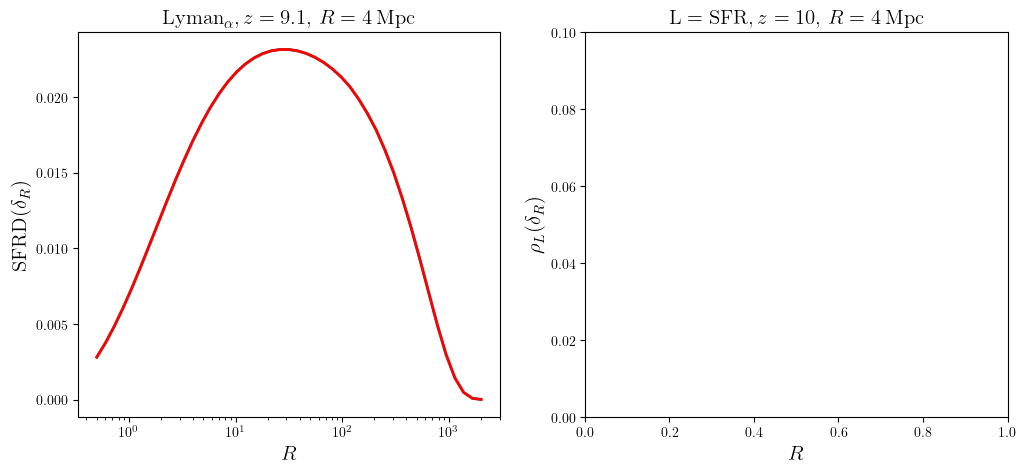

In [29]:
plt.figure(figsize=(12,5))

plt.subplot(121)
plt.semilogx(PS21_use._rs_input_mcfit,CoeffStructure_21_second.SFRD_II_dR[z_id,:,1],color=colors[2])#,label=r'$\gamma_R$')
plt.semilogx(PS21_use._rs_input_mcfit,CoeffStructure_21_second.SFRD_II_dR[z_id,:,1],color='r')#,label=r'$\gamma_{R}^{\rm NL}$')
plt.title(r'${\rm Lyman_\alpha,\,}z=%g$'%round(CoeffStructure_21_second.zintegral[z_id],1)+r'$,\,R=%g\,{\rm Mpc}$'%round(CoeffStructure_21_second.Rtabsmoo[R_id],1),fontsize=15)
plt.xlabel(r'$R$',fontsize=15)
plt.ylabel(r'${\rm SFRD}(\delta_R)$',fontsize=15)


plt.subplot(122)
plt.axhline(OIII_Yang_lin_coeff.rhoL_dR[z_id,:,1],color=colors[2])#,label=r'$\gamma_R$')
#plt.axhline(OIII_Yang_lin_coeff.rhoL_dR[z_id,:,0],color='r',label=r'$\gamma_R^{\rm NL}$')
plt.ylim(0.0,0.1)
plt.title(r'${\rm L=SFR,\,}z=%g$'%round(OIII_Yang_lin_coeff.zintegral[z_id],-1)+r'$,\,R=%g\,{\rm Mpc}$'%round(OIII_Yang._R,1),fontsize=15)
plt.xlabel(r'$R$',fontsize=15)
plt.ylabel(r'${\rho_L}(\delta_R)$',fontsize=15)

In [30]:
Lbox/Nbox

4.0

done analytical in 0.14139556884765625
Done EPS corr in 0.5398111343383789
SFR ok in 0.5401504039764404
Integrand ok in 1.1048784255981445
SFRD ok in 1.3805041313171387
rho box ok in 1.6615238189697266


Text(0, 0.5, '$\\xi_{\\rm LIM}^{RR}(r,z)$')

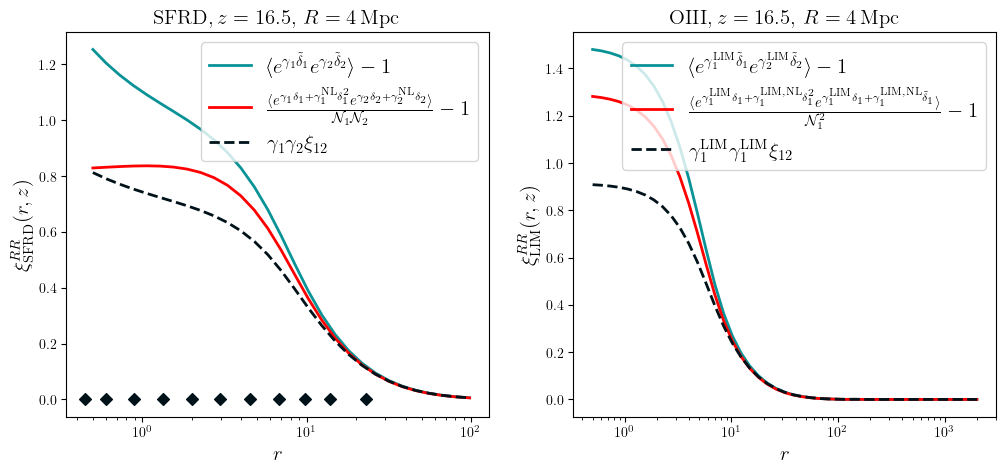

In [31]:
from powerbox import get_power
import mcfit

kmin = 2*np.pi/Lbox # 1/Mpc
k_max = kmin*Nbox # 1/Mpc
k_factor = 1.5
k_bins_edges = []
k_ceil = kmin
while (k_ceil < k_max):
    k_bins_edges.append(k_ceil)
    k_ceil *= k_factor

k_bins_edges = np.array(k_bins_edges)

z_id = 60
R_id = 11

boxes_oLIMpus = oLIMpus.maps_LIM.CoevalBoxes_percell('full',OIII_Yang_lin_coeff,OIII_Yang_corr,OIII_Yang_lin_PSLIM,CoeffStructure_21_use,OIII_Yang_quad_coeff.zintegral[z_id],OIII_Yang,AstroParams_use,HMFintclass_use,CosmoParams_use,Lbox,Nbox,1065)

SFRD_box = boxes_oLIMpus.SFRD_box

res_SFRD = get_power(
            deltax = SFRD_box,
            boxlength=Lbox,
            bins = k_bins_edges,
            dimensionless=False,
        )
pk_SFRD, kSFRD = list(res_SFRD)

rlist_SFRD, xi_SFRD =  mcfit.P2xi(kSFRD, l=0, lowring=True)(pk_SFRD, extrap = False)
plt.figure(figsize=(12,5))

plt.subplot(121)
plt.semilogx(PS21_use._rs_input_mcfit[:len(_iRnonlinear)],lin[z_id,:,R_id,R_id],color=colors[2],label=r'$\langle e^{\gamma_1\tilde{\delta}_1}e^{\gamma_2\tilde{\delta}_2}\rangle-1$')
plt.semilogx(PS21_use._rs_input_mcfit[:len(_iRnonlinear)],nonlinearcorrelation[z_id,:,R_id,R_id],color='r',label=r'$\frac{\langle e^{\gamma_1{\delta}_1+\gamma_1^{\rm NL}{\delta}_1^2}e^{\gamma_2{\delta}_2+\gamma_2^{\rm NL}{\delta}_2}\rangle}{\mathcal{N}_1\mathcal{N}_2}-1$')
plt.semilogx(PS21_use._rs_input_mcfit[:len(_iRnonlinear)],gammaTimesCorrdNL[z_id,:,R_id,R_id],color=colors[0],ls='--',label=r'$\gamma_1\gamma_2\xi_{12}$')

plt.scatter(rlist_SFRD,xi_SFRD,color=colors[0],marker='D')

plt.legend(loc=1,fontsize=15)
plt.title(r'${\rm SFRD,\,}z=%g$'%round(CoeffStructure_21_second.zintegral[z_id],1)+r'$,\,R=%g\,{\rm Mpc}$'%round(CoeffStructure_21_second.Rtabsmoo[R_id],1),fontsize=15)
plt.xlabel(r'$r$',fontsize=15)
plt.ylabel(r'$\xi_{\rm SFRD}^{RR}(r,z)$',fontsize=15)


plt.subplot(122)
plt.semilogx(OIII_Yang_lin_PSLIM._r_CF,lin_LIM[z_id],color=colors[2],label=r'$\langle e^{\gamma_1^{\rm LIM}\tilde{\delta}_1}e^{\gamma_2^{\rm LIM}\tilde{\delta}_2}\rangle-1$')
plt.semilogx(OIII_Yang_lin_PSLIM._r_CF,nonlinearcorrelation_LIM[z_id],color='r',label=r'$\frac{\langle e^{\gamma_1^{\rm LIM}{\delta}_1+\gamma_1^{\rm LIM,NL}{\delta}_1^2}e^{\gamma_1^{\rm LIM}{\delta}_1+\gamma_1^{\rm LIM,NL}\tilde{\delta}_1}\rangle}{\mathcal{N}_1^2}-1$')
plt.semilogx(OIII_Yang_lin_PSLIM._r_CF,xi_LIM_R0_z[z_id],color=colors[0],ls='--',label=r'$\gamma_1^{\rm LIM}\gamma_1^{\rm LIM}\xi_{12}$')


plt.legend(loc=1,fontsize=15)
plt.title(r'${\rm OIII,\,}z=%g$'%round(OIII_Yang_lin_coeff.zintegral[z_id],1)+r'$,\,R=%g\,{\rm Mpc}$'%round(OIII_Yang._R,1),fontsize=15)
plt.xlabel(r'$r$',fontsize=15)
plt.ylabel(r'$\xi_{\rm LIM}^{RR}(r,z)$',fontsize=15)

In [32]:
z_id = 60

boxes_oLIMpus = oLIMpus.maps_LIM.CoevalBoxes_percell('full',OIII_Yang_lin_coeff,OIII_Yang_corr,OIII_Yang_lin_PSLIM,CoeffStructure_21_use,OIII_Yang_quad_coeff.zintegral[z_id],OIII_Yang,AstroParams_use,HMFintclass_use,CosmoParams_use,Lbox,Nbox,1065)

delta_box = boxes_oLIMpus.delta_box
SFRD_box = boxes_oLIMpus.SFRD_box/np.mean(boxes_oLIMpus.SFRD_box)
full_LIM_box = boxes_oLIMpus.Inu_box


res = get_power(
            deltax = full_LIM_box,
            boxlength=Lbox,
            bins = k_bins_edges,
            dimensionless=False,
        )
pk_LIM, kLIM = list(res)

done analytical in 0.15531468391418457
Done EPS corr in 0.556250810623169
SFR ok in 0.5565817356109619
Integrand ok in 1.1352527141571045
SFRD ok in 1.438377857208252
rho box ok in 1.7244112491607666


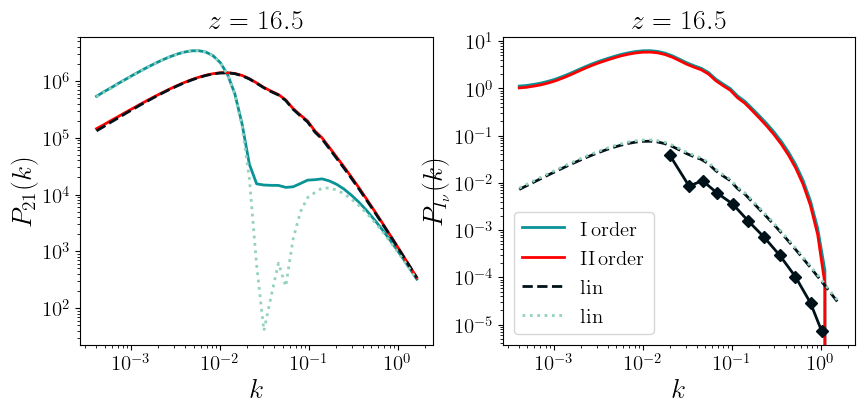

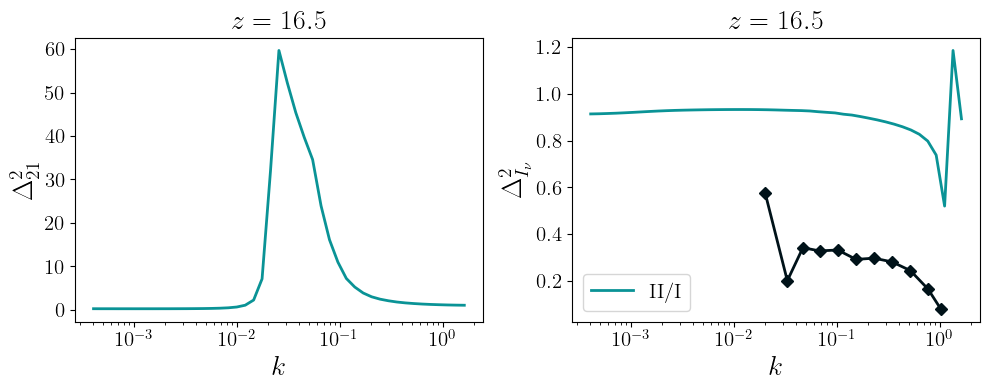

In [33]:
klist = PS21_use.klist_PS

plt.figure(figsize=(10,4))
plt.subplot(121)
plt.loglog(klist,PS21_use.Deltasq_T21[z_id]/PS21_use._k3over2pi2, '-', label=r'$\rm I\,order$',color=colors[2])
plt.loglog(klist,PS21_second.Deltasq_T21[z_id]/PS21_use._k3over2pi2, '-', label=r'$\rm II\,order$',color='r')
plt.loglog(klist,PS21_second.Deltasq_T21_lin[z_id]/PS21_use._k3over2pi2, '--', label=r'$\rm lin$',color=colors[0])
plt.loglog(klist,PS21_use.Deltasq_T21_lin[z_id]/PS21_use._k3over2pi2, ':', label=r'$\rm lin$',color=colors[3])
plt.xlabel(r'$k$',fontsize=20)
plt.ylabel(r'$P_{21}(k)$',fontsize=20)
plt.title(r'$z=%g$'%(round(CoeffStructure_21_use.zintegral[z_id],1)),fontsize=20)
#plt.legend(loc=4,fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.subplot(122)
plt.loglog(klist,OIII_Yang_lin_PSLIM._Pk_LIM[z_id], '-', label=r'$\rm I\,order$',color=colors[2])
plt.loglog(klist,OIII_Yang_quad_PSLIM._Pk_LIM[z_id], '-', label=r'$\rm II\,order$',color='r')
plt.loglog(klist,OIII_Yang_quad_PSLIM._Pk_LIM_lin[z_id], '--', label=r'$\rm lin$',color=colors[0])
plt.loglog(klist,OIII_Yang_lin_PSLIM._Pk_LIM_lin[z_id], ':', label=r'$\rm lin$',color=colors[3])

plt.loglog(kLIM,pk_LIM,marker='D')
plt.xlabel(r'$k$',fontsize=20)

plt.ylabel(r'$P_{I_\nu}(k)$',fontsize=20)
plt.title(r'$z=%g$'%(round(OIII_Yang_lin_coeff.zintegral[z_id],1)),fontsize=20)
plt.legend(loc=3,fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
#plt.ylim(10,1e5)

plt.figure(figsize=(10,4))
plt.subplot(121)
plt.semilogx(klist,PS21_second.Deltasq_T21[z_id]/PS21_use.Deltasq_T21[z_id], '-', label=r'$\rm II/I$',color=colors[2])
plt.xlabel(r'$k$',fontsize=20)
plt.ylabel(r'$\Delta_{21}^2$',fontsize=20)
plt.title(r'$z=%g$'%(round(CoeffStructure_21_use.zintegral[z_id],1)),fontsize=20)
#plt.legend(loc=3,fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.subplot(122)
plt.semilogx(klist,OIII_Yang_quad_PSLIM._Pk_LIM[z_id]/OIII_Yang_lin_PSLIM._Pk_LIM[z_id], '-', label=r'$\rm II/I$',color=colors[2])

plt.semilogx(kLIM,pk_LIM/interp1d(klist,OIII_Yang_lin_PSLIM._Pk_LIM_lin[z_id],bounds_error=False,fill_value='extrapolate')(kLIM),marker='D')

plt.xlabel(r'$k$',fontsize=20)
plt.ylabel(r'$\Delta_{I_\nu}^2$',fontsize=20)
plt.title(r'$z=%g$'%(round(OIII_Yang_lin_coeff.zintegral[z_id],1)),fontsize=20)
plt.legend(loc=3,fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
#plt.ylim(-1,100)

plt.tight_layout()

In [34]:
OIII_Yang_lin_coeff.coeff2_LIM[30]*OIII_Yang_lin_coeff.coeff1_LIM[30]

array([1.04210094])

In [35]:
OIII_Yang_lin_coeff.rhoL_avg[30]*OIII_Yang_lin_coeff.coeff1_LIM[30]

np.float64(0.8981102291297469)

In [36]:
OIII_Yang_lin_coeff.Inu_avg[30]

np.float64(1.0421009371794066)

(10.0, 25.0)

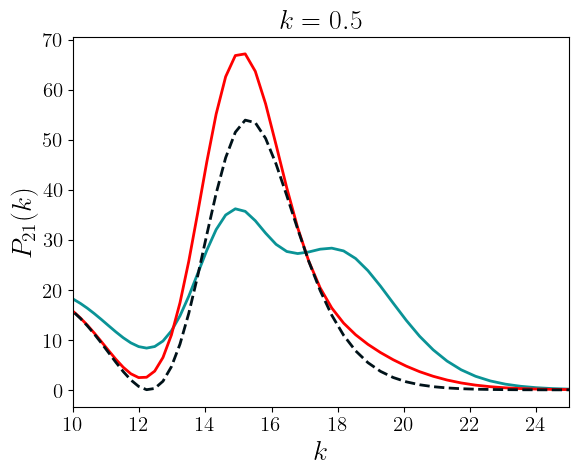

In [37]:
plt.plot(CoeffStructure_21_use.zintegral,PS21_use.Deltasq_T21[:,38], '-', label=r'$\rm I\,order$',color=colors[2])
plt.plot(CoeffStructure_21_use.zintegral,PS21_second.Deltasq_T21[:,38], '-', label=r'$\rm II\,order$',color='r')
plt.plot(CoeffStructure_21_use.zintegral,PS21_second.Deltasq_T21_lin[:,38], '--', label=r'$\rm lin$',color=colors[0])
plt.xlabel(r'$k$',fontsize=20)
plt.ylabel(r'$P_{21}(k)$',fontsize=20)
plt.title(r'$k=%g$'%(round(klist[38],1)),fontsize=20)
#plt.legend(loc=4,fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlim(10,25)


## 3) Map Production

$\delta_{21} = \bar{T}_{21}\left[{\rm FT}\left(\dfrac{P_{T_{21}\delta}}{P_{\delta\delta}}\right)_{\rm map} + {\rm FT}\left(\dfrac{P_{21}(k)-P_{21}^{\rm lin}(k)}{\bar{T}^2_{21}}\right)_{\rm map}\right]$

$\delta_{I_\nu} = \bar{I}_{\nu}\left[{\rm FT}\left(\dfrac{P_{I_{\nu}\delta}}{P_{\delta\delta}}\right)_{\rm map} + {\rm FT}\left(\dfrac{P_{I_\nu}(k)-P_{I_\nu}^{\rm lin}(k)}{\bar{I}^2_{\nu}}\right)_{\rm map}\right]
$

$P_{I_{\nu}\delta}=(c_1^{\rm LIM}c_2^{\rm LIM}\gamma^{\rm LIM})\xi_m(z)$
$-P_{I_\nu}^{\rm lin} = (c_1^{\rm LIM}c_2^{\rm LIM}\gamma^{\rm LIM})^2\xi_m(z)$

In [38]:
get_z = 7.
seed = 1065
_islice = 0
RSDMODE = 0 

Lbox = 100
Ncell = 50


(<Figure size 500x300 with 4 Axes>, <Axes: >)

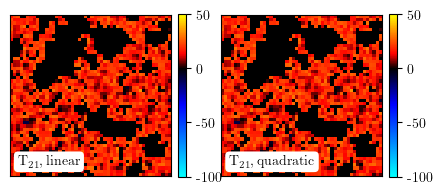

In [39]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(5, 3))

oLIMpus.plotting_module.plot_T21(7.,Lbox,Ncell,seed,0,AstroParams_use,ClassyCosmo_use, HMFintclass_use,CosmoParams_use,ZMIN,_islice,r'${\rm linear}$',ax[0],fig)
oLIMpus.plotting_module.plot_T21(7.,Lbox,Ncell,seed,0,AstroParams_second,ClassyCosmo_use, HMFintclass_use,CosmoParams_use,ZMIN,_islice,r'${\rm quadratic}$',ax[1],fig)


KeyboardInterrupt: 

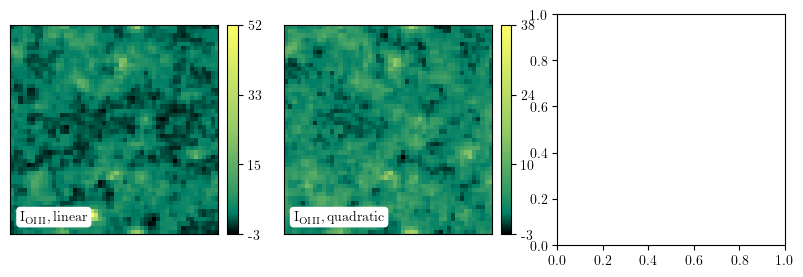

In [40]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 3))

oLIMpus.plotting_module.plot_Inu(7.,Lbox,Ncell,seed,0,True,OIII_Yang,AstroParams_use,ClassyCosmo_use,HMFintclass_use,CosmoParams_use,ZMIN,_islice,r'$\rm linear$',ax[0],fig)
oLIMpus.plotting_module.plot_Inu(7.,Lbox,Ncell,seed,0,True,OIII_Yang,AstroParams_second,ClassyCosmo_use,HMFintclass_use,CosmoParams_use,ZMIN,_islice,r'$\rm quadratic$',ax[1],fig)
oLIMpus.plotting_module.plot_Inu(7.,Lbox,Ncell,seed,0,False,OIII_Yang,AstroParams_second,ClassyCosmo_use,HMFintclass_use,CosmoParams_use,ZMIN,_islice,r'$\rm percelll$',ax[2],fig)


In [ ]:
Maps_line1 = oLIMpus.CoevalBox_LIM_zeuslike(OIII_Yang_lin_coeff,OIII_Yang_corr,OIII_Yang_lin_PSLIM,7.,Lbox,Ncell,1,seed,False)
coeval_slice_line = Maps_line1.LIMmap[_islice]

In [ ]:
(PS21_use.Deltasq_T21[60,:]-PS21_use.Deltasq_T21_lin[60,:])/(OIII_Yang_lin_PSLIM.klist_PS**3/(2*np.pi**2))/CoeffStructure_21_use.T21avg[60]**2

array([1.69001101e+00, 1.68975566e+00, 1.68998596e+00, 1.68975798e+00,
       1.68993582e+00, 1.68974375e+00, 1.68985655e+00, 1.68968330e+00,
       1.68971861e+00, 1.68952664e+00, 1.68945229e+00, 1.68917235e+00,
       1.68890965e+00, 1.68840832e+00, 1.68778240e+00, 1.68679228e+00,
       1.68543079e+00, 1.68340168e+00, 1.68051163e+00, 1.67626040e+00,
       1.67005299e+00, 1.66076692e+00, 1.64667729e+00, 1.62475393e+00,
       1.59020911e+00, 1.53592317e+00, 1.45343299e+00, 1.33593118e+00,
       1.18415243e+00, 1.00828920e+00, 8.22928582e-01, 6.43741851e-01,
       4.81568464e-01, 3.44862606e-01, 2.37303295e-01, 1.57405792e-01,
       1.00845561e-01, 6.24612529e-02, 3.74534870e-02, 2.17016491e-02,
       1.20875210e-02, 6.39327161e-03, 3.13431003e-03, 1.34409852e-03,
       4.26852726e-04])

In [ ]:
(OIII_Yang_lin_PSLIM.Deltasq_LIM[60,:]-OIII_Yang_lin_PSLIM.Deltasq_LIM_lin[60,:])/(OIII_Yang_lin_PSLIM.klist_PS**3/(2*np.pi**2))/OIII_Yang_lin_coeff.Inu_avg[60]**2

array([ 5.40205258e+03,  5.56588603e+03,  5.86531659e+03,  6.24081268e+03,
        6.81405563e+03,  7.57304603e+03,  8.62944552e+03,  9.98589192e+03,
        1.16959736e+04,  1.36816218e+04,  1.58530130e+04,  1.80618303e+04,
        2.03161630e+04,  2.27109284e+04,  2.51291375e+04,  2.72223603e+04,
        2.89634710e+04,  3.00186176e+04,  3.01541633e+04,  2.91352564e+04,
        2.68931908e+04,  2.36512866e+04,  2.00151479e+04,  1.68086044e+04,
        1.45421921e+04,  1.28113265e+04,  1.04385584e+04,  7.58137008e+03,
        5.96252299e+03,  4.76865958e+03,  3.32379703e+03,  2.56339866e+03,
        1.80710559e+03,  1.25980952e+03,  8.66508897e+02,  5.74993249e+02,
        3.63521411e+02,  2.14680353e+02,  1.15132013e+02,  5.33689349e+01,
        1.96405640e+01,  4.80004056e+00,  3.33446554e-01, -3.85164759e-01,
       -5.55096671e-01])

In [ ]:
Maps_line1.LIMmapNL

array([[[-2.30339465e+00, -9.78173084e-01,  6.17942087e-02, ...,
         -2.13308306e+00, -2.25078479e+00, -2.16584529e+00],
        [-8.37269692e-01,  2.27782904e+00,  1.17922674e+00, ...,
         -1.53831743e+00, -2.10627742e+00, -1.78046305e+00],
        [-6.91355995e-01,  8.28311732e-01,  1.61526082e+00, ...,
         -1.89109570e+00, -1.45951875e+00, -1.47370656e+00],
        ...,
        [-1.86930346e+00, -8.78989846e-01, -8.64738293e-01, ...,
         -2.17761588e+00, -2.11991546e+00, -2.20142774e+00],
        [-2.30407703e+00, -2.10077787e+00, -7.33355610e-01, ...,
         -1.71121864e+00, -1.87237062e+00, -1.98260042e+00],
        [-2.45907526e+00, -1.96478429e+00, -5.57008330e-01, ...,
         -1.55733210e+00, -2.14042827e+00, -2.19605740e+00]],

       [[-2.19430264e+00, -1.39712480e+00, -1.20664965e+00, ...,
         -1.01681791e+00, -1.20914326e+00, -1.67273913e+00],
        [-1.50098497e+00, -2.73246377e-01, -5.33219575e-02, ...,
         -5.63922912e-01, -3.61856622e

In [ ]:
Maps_quad = oLIMpus.CoevalBox_LIM_zeuslike(OIII_Yang_quad_coeff,OIII_Yang_corr,OIII_Yang_quad_PSLIM,7.,Lbox,Ncell,1,seed)
coeval_slice_line_quad = Maps_quad.LIMmap[_islice]

(array([  0.,   0.,   1.,  49., 595., 939., 566., 215.,  81.,  22.,  13.,
          5.,   6.,   3.,   1.,   1.,   0.,   0.]),
 array([-10.        ,  -7.77777778,  -5.55555556,  -3.33333333,
         -1.11111111,   1.11111111,   3.33333333,   5.55555556,
          7.77777778,  10.        ,  12.22222222,  14.44444444,
         16.66666667,  18.88888889,  21.11111111,  23.33333333,
         25.55555556,  27.77777778,  30.        ]),
 <BarContainer object of 18 artists>)

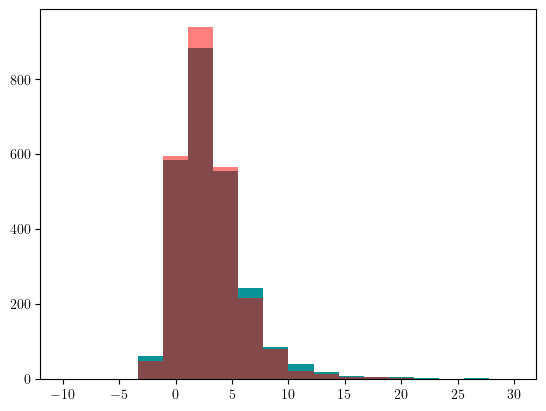

In [ ]:
plt.figure()
plt.hist(coeval_slice_line.flatten(),bins = np.linspace(-10,30,19),color=colors[2])
plt.hist(coeval_slice_line_quad.flatten(),bins = np.linspace(-10,30,19),color='r',alpha=0.5)
#plt.hist(-coeval_slice_line_quad.flatten()+coeval_slice_line.flatten(),color=colors[2])
#plt.hist(coeval_slice_line_quad.flatten(),bins = np.linspace(-1,10,29),color='r',alpha=.5)


(-0.15, 0.01)

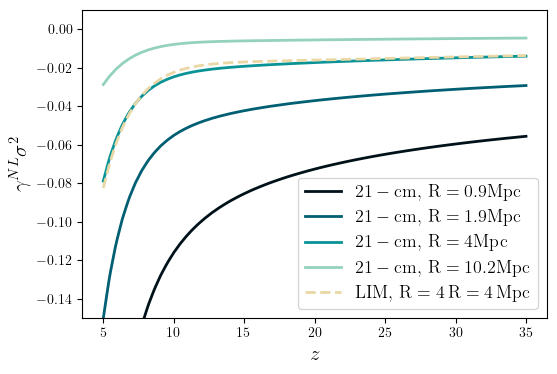

In [ ]:
R_ids = [3,7,11,16]

plt.figure(figsize=(6,4))
for i in R_ids:
    plt.plot(CoeffStructure_21_use.zintegral,g1NL[:,0,i,0],label=r'$\rm 21-cm,\,R=%g{\rm Mpc}$'%round(CoeffStructure_21_use.Rtabsmoo[i],1) )

plt.plot(OIII_Yang_lin_coeff.zintegral,g1NL_LIM,label=r'$\rm LIM,\,R=%g\,{R=4\,{\rm Mpc}}$'%round(OIII_Yang._R,1),ls='--' )
plt.legend(fontsize=13)
plt.xlabel(r'$z$',fontsize=15)
plt.ylabel(r'$\gamma^{NL}\sigma^2$',fontsize=15)
plt.ylim(-0.15,.01)